<a href="https://colab.research.google.com/github/esemsc-dda24/ci_mpm/blob/master/Assessment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Assessment 1**

For our first assessment, our goal is to solve an imputation problem: we will create a neural network architecture that learns how to recover missing portions of an image.

This is an important problem in magnetic resonance imaging (MRI), where patient scans are often limited to a few areas to avoid lengthy scanning times.

In particular, we are going to focus on images of human heads. We have managed to gain access to one hundred images of patient's heads but, unfortunately, these images have a significant portion of missing information. Your goal during the assessment is to design a neural network that can recover these missing portions.

<br>

---

<br>

We do not have access to the labels for the images we want to recover, so we will have to be a bit creative to obtain a workable dataset on which to train our neural network.

Fortunately for us, we have access to a generative model that has been trained to produce realistic-looking MRI images of patient's heads. Using this model, you will create an appropriate dataset to train your architecture. We have provided you with the basic setup code to start using this generative model in **Question 1** below.

The corrupted images that we want to recover are contained in the numpy file `test_set.npy` of this repository. The file contains 100 patient images with a size of 64x64 pixels.

The architecture that you design in this assessment should use the artificially-generated dataset in order to recover the missing information in the images contained in `test_set.npy`.

<br>

All answers to the assessment should be contained within the structure below, but you are free to add new code and text cells as required to your answers. Read the text for each question and follow the instructions carefully. Answers that do not follow this structure will not be marked. **Do NOT change the name of this file.**

Please, **make sure to execute all your cells and save the result of the execution**. We will only mark cells that have been executed and will not execute any cells ourselves.

<br>

---

<br>

<br><br>

## **Question 1**  (25%)

Using the provided image-generation network, create a dataset of brain images that will later be used to train your chosen architecture.

Given that you will likely want to use this dataset multiple times during training, we recommend that you save the generated images to an appropriate folder in your GDrive.

Once you have generated your dataset, load and display ten of your generated images here.

We have also provided you with some corrupted images in the file `test_set.npy` of this repository. You should also load and display ten of these corrupted images here.

Below, we have provided template code, including some required downloads and installations, so that you can easily use the trained generative model. Sample generation in this model is done using the function `generate`, and is controlled by some input arguments. It is your job to figure out a sensible set of parameters that will produce images that are useful for the requirements of your task.

<br>

## Inspecting corrupted dataset

To achieve an optimal result for the reconstruction of the images, we are interested in generating training images that are similar to what we expected our corrupted data to be. As such, first we analyse the corrupted data:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import torch
from torch.utils.data import Dataset, DataLoader
import random
import torch
import torch.nn as nn
import torchvision.utils
from torchvision.transforms import Compose, ToTensor, Normalize
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
import os, glob
from PIL import Image
from progressbar import ProgressBar
from torchvision.transforms import Compose, ToTensor, GaussianBlur, Resize, Grayscale, Lambda
from torchsummary import summary
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install torchsummary progressbar2 livelossplot monai -q
from progressbar import ProgressBar
from livelossplot import PlotLosses

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 69.6 MB/s eta 0:00:00


In [ ]:
data_test = np.load('/content/drive/MyDrive/Colab Notebooks/test_set.npy')

data_test.shape # as expected

(100, 1, 64, 64)

In [ ]:
def plot_images(images, num_images=10, grid_shape=(2, 5), cmap='plasma'):

    # Reshape if the images have a single channel
    if images.shape[1] == 1:
        images = images[:, 0, :, :]

    # Determine the number of rows and columns
    rows, cols = grid_shape
    assert rows * cols >= num_images, "Grid shape must fit all images."

    # Plot the images
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    axes = axes.flatten()

    for i in range(rows * cols):
        if i < num_images:
            axes[i].imshow(images[i], cmap=cmap)
            axes[i].set_title(f"Image {i + 1}", fontsize=8)
            axes[i].axis('off')
        else:
            axes[i].axis('off')  # Hide unused subplots

    plt.tight_layout(pad=0.8)
    plt.show()

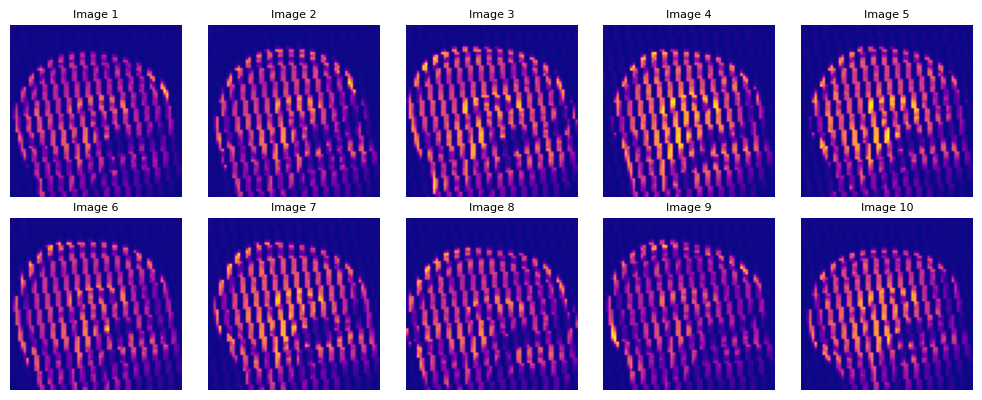

In [ ]:
plot_images(data_test, num_images=10, grid_shape=(2, 5))

### Deciding best generator parameters

In [ ]:
!unzip /content/drive/MyDrive/Colab\ Notebooks/cw1_files.zip -d ./
!chmod +x run.sh
!bash ./run.sh
sys.path.append('/content/ese-invldm')

sys.path.append('/content/ese-invldm')
from ese_invldm import generate

Archive:  /content/drive/MyDrive/Colab Notebooks/cw1_files.zip
  inflating: ./files/config_training.yml  
  inflating: ./run.sh                
  inflating: ./ese-invldm/setup.py   
  inflating: ./files/default_config.yml  
  inflating: ./ese-invldm/ese_invldm/ese_invldm.py  
  inflating: ./ese-invldm/ese_invldm/__init__.py  
  inflating: ./files/autoencoder/autoencoder_ckpt_latest.pth  
  inflating: ./files/diffusion/diffusion_ckpt_latest.pth  
Cloning the repository from https://github.com/dpelacani/InverseLDM.git...
Cloning into 'InverseLDM'...
remote: Enumerating objects: 1331, done.
remote: Counting objects: 100% (261/261), done.
remote: Compressing objects: 100% (161/161), done.
remote: Total 1331 (delta 167), reused 182 (delta 100), pack-reused 1070 (from 1)
Receiving objects: 100% (1331/1331), 467.16 KiB | 691.00 KiB/s, done.
Resolving deltas: 100% (875/875), done.
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 4.3 MB/s eta 0

/usr/local/lib/python3.10/dist-packages/generative/networks/layers/vector_quantizer.py:86: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @torch.cuda.amp.autocast(enabled=False)
/usr/local/lib/python3.10/dist-packages/generative/networks/layers/vector_quantizer.py:124: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @torch.cuda.amp.autocast(enabled=False)


To decide which parameters are the best we must be careful not to change multiple parameters at the same time. First we notice that "ddim" produces adequate results and "ddpm" does not produce any good results.

In [ ]:
def plot_batch(x):

    plt.figure(figsize=(15, 15))
    grid = torchvision.utils.make_grid(x, nrow=5)
    plt.imshow(grid[0], cmap='plasma')
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [ ]:
samples_ddim = generate(batch_size=10, scheduler="ddim", temperature=0.5, num_inference_steps=25, num_samples=10, seed=42)
samples_ddpm = generate(batch_size=10, scheduler="ddpm", temperature=0.5, num_inference_steps=25, num_samples=10, seed=42)

/content/InverseLDM/invldm/runners/base_runner.py:137: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_states = torch.load(path)


Batch 0


100%|██████████| 25/25 [00:01<00:00, 18.50it/s]


Batch 0


100%|██████████| 25/25 [00:00<00:00, 27.99it/s]


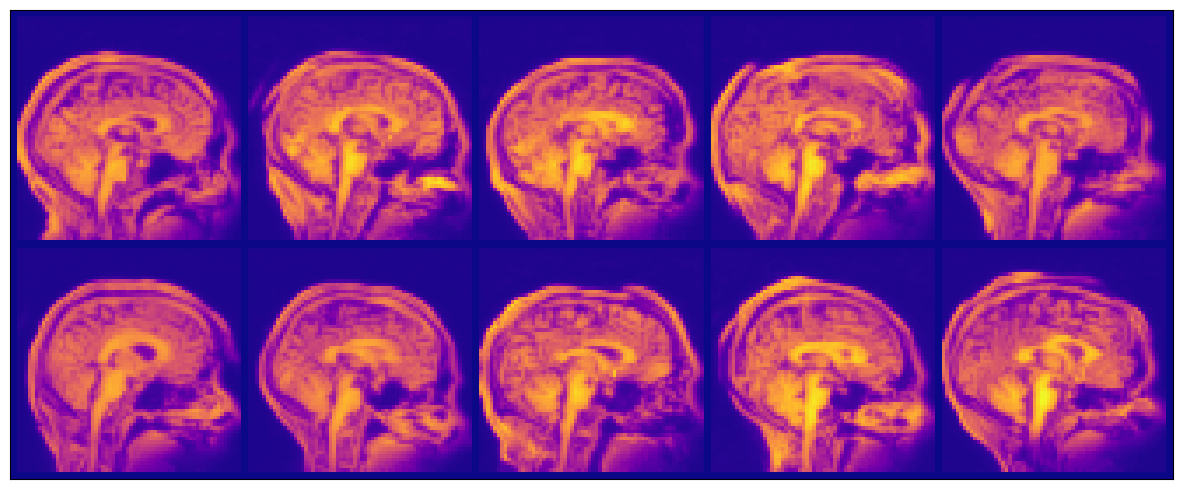

In [ ]:
plot_batch(samples_ddim[0].cpu())

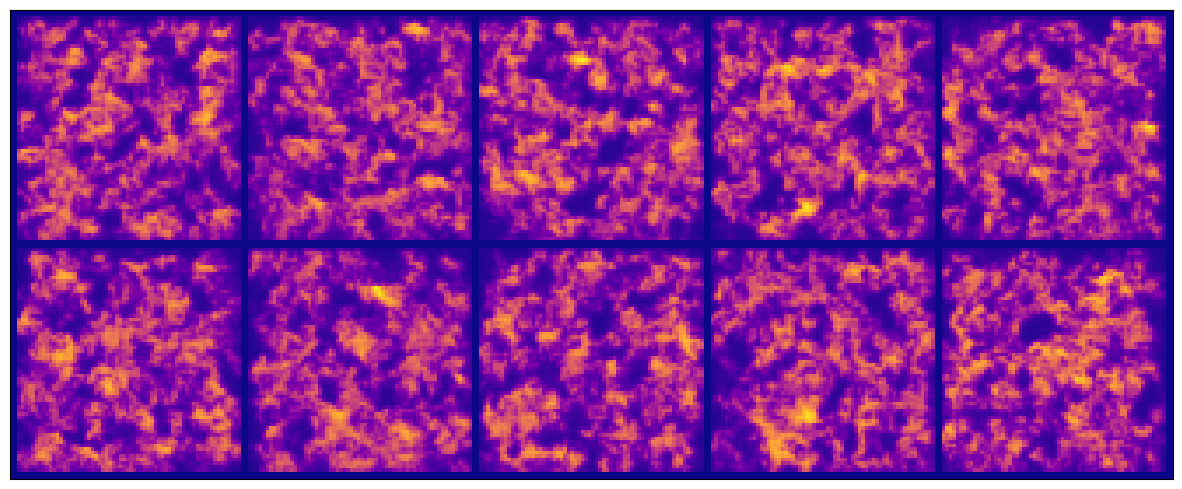

In [ ]:
plot_batch(samples_ddpm[0].cpu())

Next we notice that temperature does not seem to change our results significantly for an inference step of 25. Since for higher values produce more diverse outputs we will consider a temperature of 0.8.

In [ ]:
samples_T01 = generate(batch_size=10, scheduler="ddim", temperature=0.1, num_inference_steps=25, num_samples=10, seed=42)
samples_T05 = generate(batch_size=10, scheduler="ddim", temperature=0.5, num_inference_steps=25, num_samples=10, seed=42)
samples_T08 = generate(batch_size=10, scheduler="ddim", temperature=0.8, num_inference_steps=25, num_samples=10, seed=42)

Batch 0


100%|██████████| 25/25 [00:00<00:00, 29.93it/s]


Batch 0


100%|██████████| 25/25 [00:00<00:00, 29.78it/s]


Batch 0


100%|██████████| 25/25 [00:00<00:00, 28.15it/s]


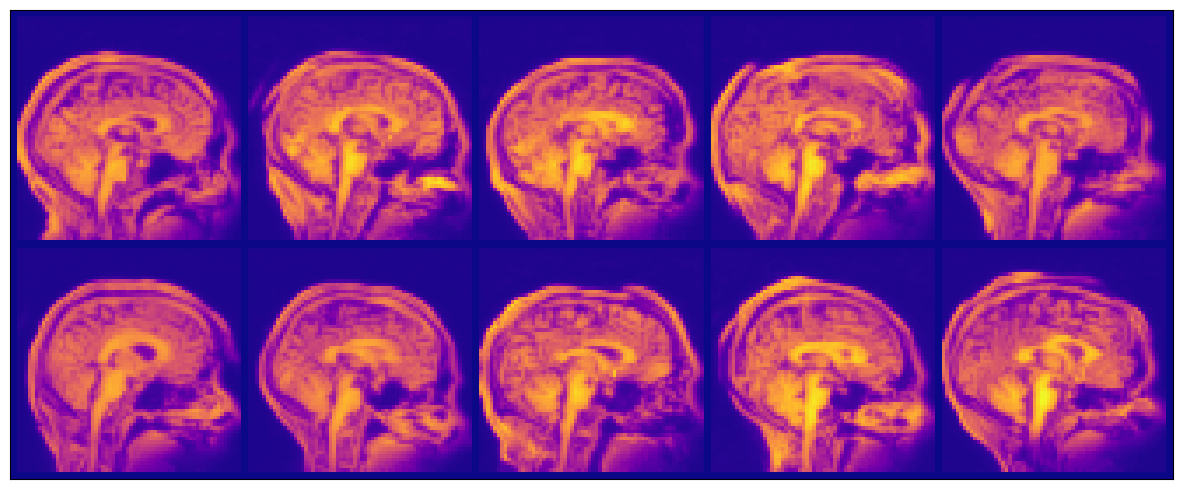

In [ ]:
plot_batch(samples_T01[0].cpu())

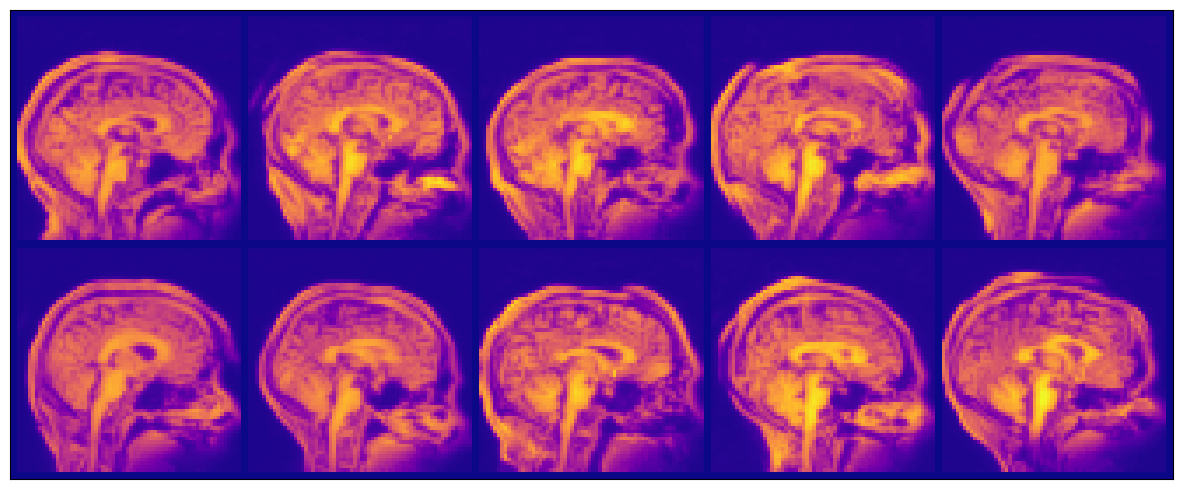

In [ ]:
plot_batch(samples_T05[0].cpu())

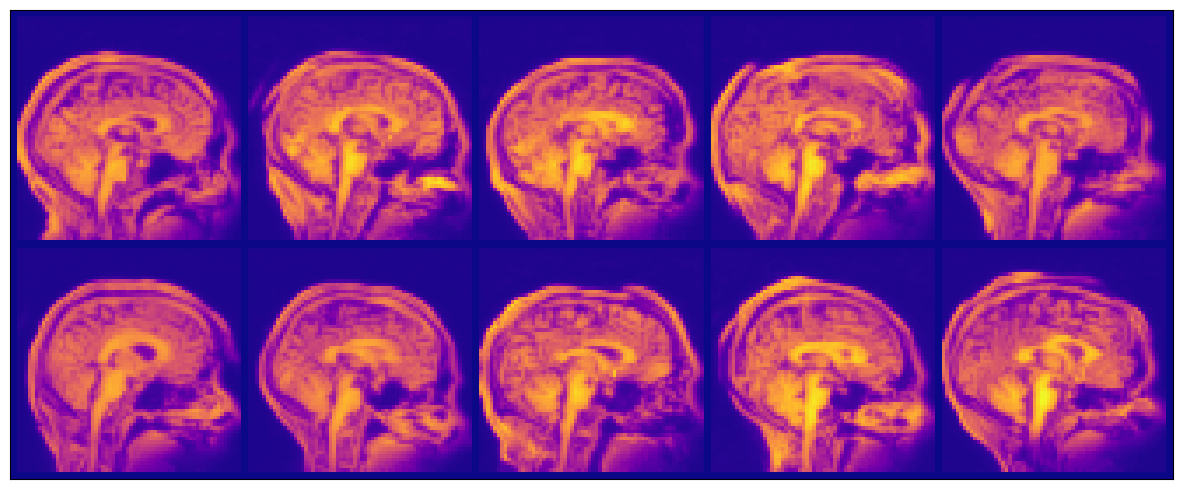

In [ ]:
plot_batch(samples_T08[0].cpu())

As we can see more clearly in the last image for the inference step of 25 the cranium does not seem to be fully detailed (it seems it is open). As we increase it to 50 and 100 we see that there is slightly more detail. After comparing we the test set images we decide to go with 50 since it is more representative of the test set.

In [ ]:
samples_NI25 = generate(batch_size=10, scheduler="ddim", temperature=0.8, num_inference_steps=25, num_samples=10, seed=42)
samples_NI50 = generate(batch_size=10, scheduler="ddim", temperature=0.8, num_inference_steps=50, num_samples=10, seed=42)
samples_NI100 = generate(batch_size=10, scheduler="ddim", temperature=0.8, num_inference_steps=50, num_samples=10, seed=42)

Batch 0


100%|██████████| 25/25 [00:00<00:00, 30.50it/s]


Batch 0


100%|██████████| 50/50 [00:01<00:00, 31.35it/s]


Batch 0


100%|██████████| 50/50 [00:01<00:00, 31.60it/s]


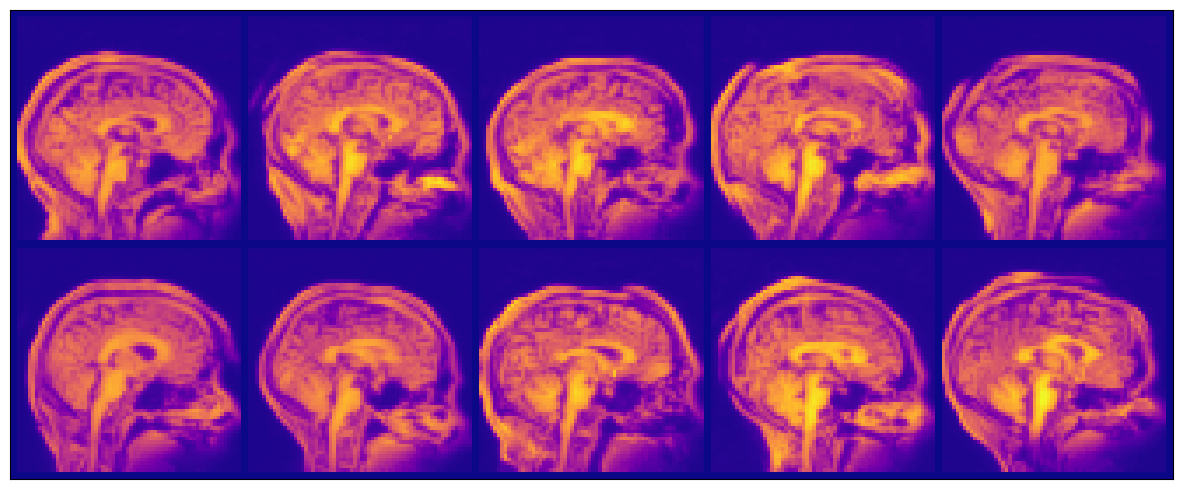

In [ ]:
plot_batch(samples_NI25[0].cpu())

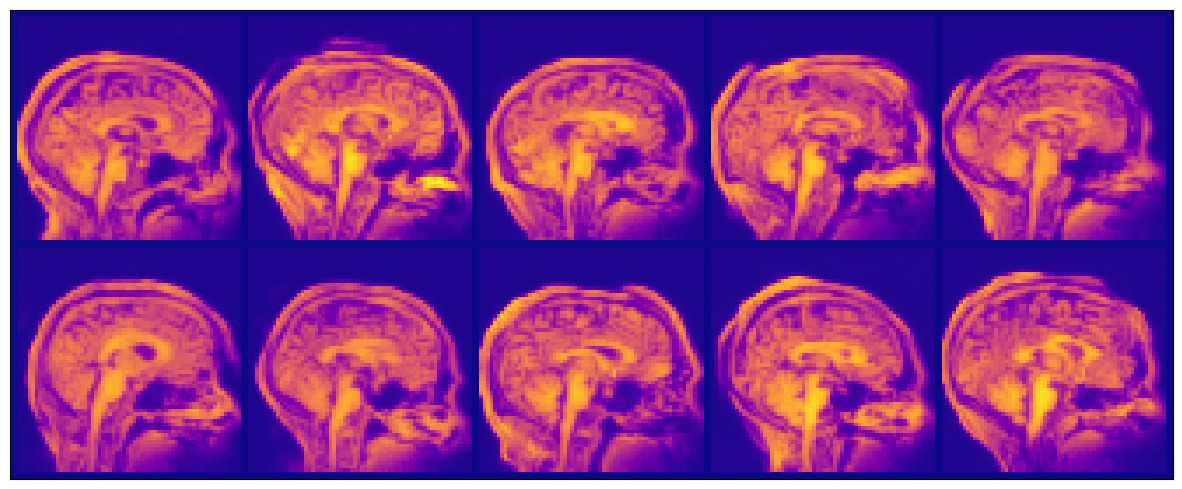

In [ ]:
plot_batch(samples_NI50[0].cpu())

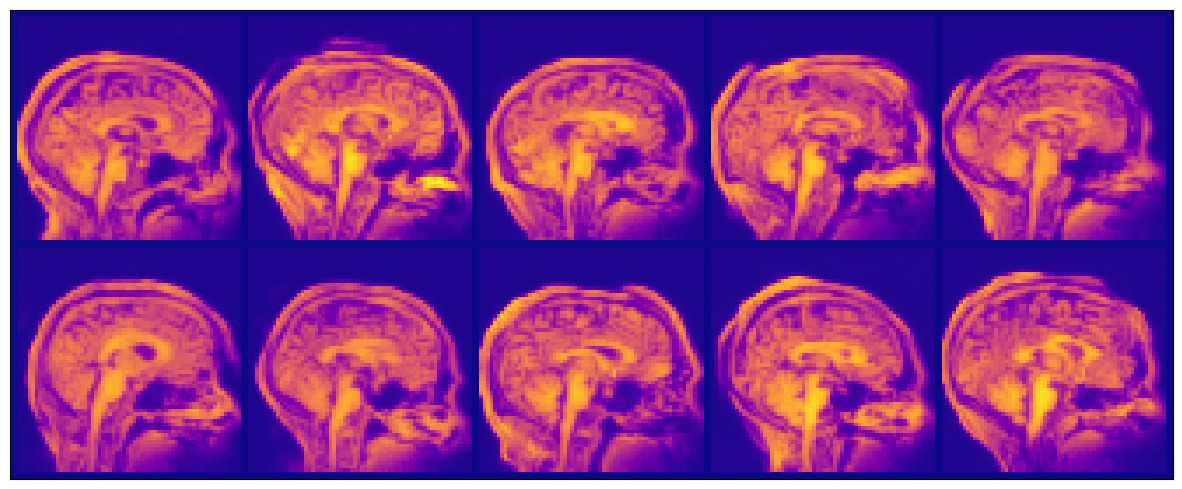

In [ ]:
plot_batch(samples_NI100[0].cpu())

### 10 Images of the Final Choice

**Loading and displaying ten of my final choice for generated images here.**

Since the results of the models were very good there was no need to come back and play with the parameters.

Batch 0


100%|██████████| 50/50 [00:01<00:00, 31.60it/s]


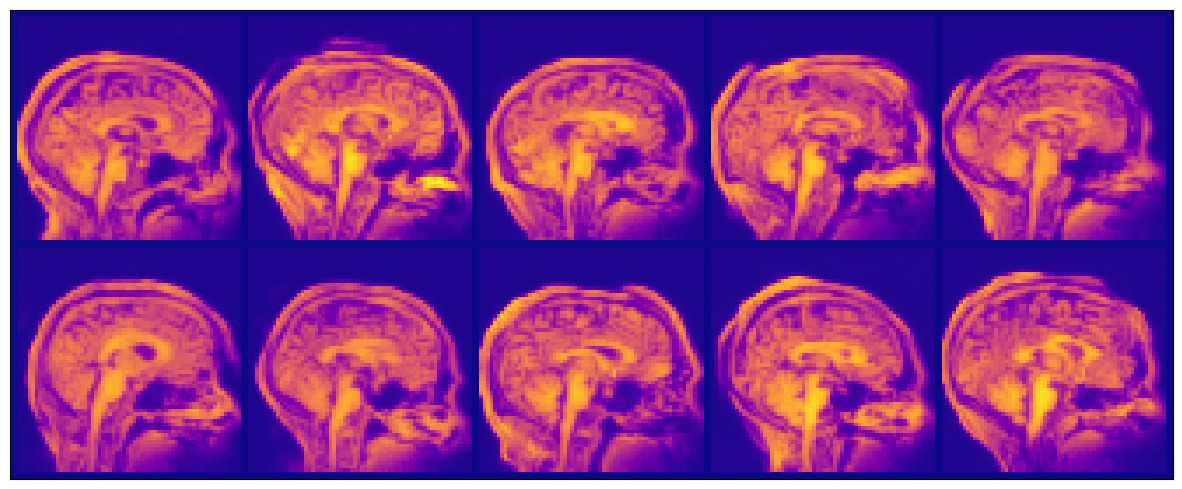

In [ ]:
samples_NI50 = generate(batch_size=10, scheduler="ddim", temperature=0.8, num_inference_steps=50, num_samples=10, seed=42)
plot_batch(samples_NI50[0].cpu())

In [ ]:
samples_final = generate(batch_size=32, scheduler="ddim", temperature=0.8, num_inference_steps=50, num_samples= 4096, seed=42)

Batch 0


100%|██████████| 50/50 [00:03<00:00, 15.64it/s]


Batch 1


100%|██████████| 50/50 [00:03<00:00, 15.98it/s]


Batch 2


100%|██████████| 50/50 [00:03<00:00, 15.97it/s]


Batch 3


100%|██████████| 50/50 [00:03<00:00, 15.99it/s]


Batch 4


100%|██████████| 50/50 [00:03<00:00, 15.99it/s]


Batch 5


100%|██████████| 50/50 [00:03<00:00, 15.98it/s]


Batch 6


100%|██████████| 50/50 [00:03<00:00, 15.95it/s]


Batch 7


100%|██████████| 50/50 [00:03<00:00, 16.00it/s]


Batch 8


100%|██████████| 50/50 [00:03<00:00, 15.99it/s]


Batch 9


100%|██████████| 50/50 [00:03<00:00, 15.96it/s]


Batch 10


100%|██████████| 50/50 [00:03<00:00, 16.00it/s]


Batch 11


100%|██████████| 50/50 [00:03<00:00, 15.80it/s]


Batch 12


100%|██████████| 50/50 [00:03<00:00, 15.98it/s]


Batch 13


100%|██████████| 50/50 [00:03<00:00, 15.95it/s]


Batch 14


100%|██████████| 50/50 [00:03<00:00, 15.99it/s]


Batch 15


100%|██████████| 50/50 [00:03<00:00, 16.00it/s]


Batch 16


100%|██████████| 50/50 [00:03<00:00, 15.99it/s]


Batch 17


100%|██████████| 50/50 [00:03<00:00, 15.99it/s]


Batch 18


100%|██████████| 50/50 [00:03<00:00, 16.00it/s]


Batch 19


100%|██████████| 50/50 [00:03<00:00, 16.00it/s]


Batch 20


100%|██████████| 50/50 [00:03<00:00, 15.98it/s]


Batch 21


100%|██████████| 50/50 [00:03<00:00, 15.97it/s]


Batch 22


100%|██████████| 50/50 [00:03<00:00, 16.00it/s]


Batch 23


100%|██████████| 50/50 [00:03<00:00, 15.98it/s]


Batch 24


100%|██████████| 50/50 [00:03<00:00, 15.98it/s]


Batch 25


100%|██████████| 50/50 [00:03<00:00, 15.97it/s]


Batch 26


100%|██████████| 50/50 [00:03<00:00, 15.99it/s]


Batch 27


100%|██████████| 50/50 [00:03<00:00, 15.98it/s]


Batch 28


100%|██████████| 50/50 [00:03<00:00, 15.99it/s]


Batch 29


100%|██████████| 50/50 [00:03<00:00, 15.82it/s]


Batch 30


100%|██████████| 50/50 [00:03<00:00, 15.98it/s]


Batch 31


100%|██████████| 50/50 [00:03<00:00, 15.98it/s]


Batch 32


100%|██████████| 50/50 [00:03<00:00, 16.00it/s]


Batch 33


100%|██████████| 50/50 [00:03<00:00, 15.95it/s]


Batch 34


100%|██████████| 50/50 [00:03<00:00, 15.98it/s]


Batch 35


100%|██████████| 50/50 [00:03<00:00, 16.00it/s]


Batch 36


100%|██████████| 50/50 [00:03<00:00, 16.00it/s]


Batch 37


100%|██████████| 50/50 [00:03<00:00, 15.95it/s]


Batch 38


100%|██████████| 50/50 [00:03<00:00, 16.00it/s]


Batch 39


100%|██████████| 50/50 [00:03<00:00, 16.01it/s]


Batch 40


100%|██████████| 50/50 [00:03<00:00, 16.00it/s]


Batch 41


100%|██████████| 50/50 [00:03<00:00, 15.95it/s]


Batch 42


100%|██████████| 50/50 [00:03<00:00, 16.01it/s]


Batch 43


100%|██████████| 50/50 [00:03<00:00, 16.00it/s]


Batch 44


100%|██████████| 50/50 [00:03<00:00, 15.97it/s]


Batch 45


100%|██████████| 50/50 [00:03<00:00, 15.95it/s]


Batch 46


100%|██████████| 50/50 [00:03<00:00, 16.00it/s]


Batch 47


100%|██████████| 50/50 [00:03<00:00, 16.00it/s]


Batch 48


100%|██████████| 50/50 [00:03<00:00, 15.79it/s]


Batch 49


100%|██████████| 50/50 [00:03<00:00, 15.97it/s]


Batch 50


100%|██████████| 50/50 [00:03<00:00, 16.00it/s]


Batch 51


100%|██████████| 50/50 [00:03<00:00, 15.99it/s]


Batch 52


100%|██████████| 50/50 [00:03<00:00, 15.97it/s]


Batch 53


100%|██████████| 50/50 [00:03<00:00, 15.98it/s]


Batch 54


100%|██████████| 50/50 [00:03<00:00, 15.99it/s]


Batch 55


100%|██████████| 50/50 [00:03<00:00, 15.99it/s]


Batch 56


100%|██████████| 50/50 [00:03<00:00, 16.00it/s]


Batch 57


100%|██████████| 50/50 [00:03<00:00, 15.98it/s]


Batch 58


100%|██████████| 50/50 [00:03<00:00, 16.00it/s]


Batch 59


100%|██████████| 50/50 [00:03<00:00, 15.99it/s]


Batch 60


100%|██████████| 50/50 [00:03<00:00, 15.99it/s]


Batch 61


100%|██████████| 50/50 [00:03<00:00, 15.97it/s]


Batch 62


100%|██████████| 50/50 [00:03<00:00, 15.99it/s]


Batch 63


100%|██████████| 50/50 [00:03<00:00, 15.99it/s]


Batch 64


100%|██████████| 50/50 [00:03<00:00, 16.00it/s]


Batch 65


100%|██████████| 50/50 [00:03<00:00, 15.97it/s]


Batch 66


100%|██████████| 50/50 [00:03<00:00, 15.97it/s]


Batch 67


100%|██████████| 50/50 [00:03<00:00, 15.86it/s]


Batch 68


100%|██████████| 50/50 [00:03<00:00, 15.99it/s]


Batch 69


100%|██████████| 50/50 [00:03<00:00, 15.97it/s]


Batch 70


100%|██████████| 50/50 [00:03<00:00, 15.99it/s]


Batch 71


100%|██████████| 50/50 [00:03<00:00, 15.99it/s]


Batch 72


100%|██████████| 50/50 [00:03<00:00, 16.00it/s]


Batch 73


100%|██████████| 50/50 [00:03<00:00, 15.97it/s]


Batch 74


100%|██████████| 50/50 [00:03<00:00, 15.97it/s]


Batch 75


100%|██████████| 50/50 [00:03<00:00, 15.98it/s]


Batch 76


100%|██████████| 50/50 [00:03<00:00, 16.00it/s]


Batch 77


100%|██████████| 50/50 [00:03<00:00, 15.99it/s]


Batch 78


100%|██████████| 50/50 [00:03<00:00, 15.99it/s]


Batch 79


100%|██████████| 50/50 [00:03<00:00, 15.99it/s]


Batch 80


100%|██████████| 50/50 [00:03<00:00, 16.00it/s]


Batch 81


100%|██████████| 50/50 [00:03<00:00, 15.98it/s]


Batch 82


100%|██████████| 50/50 [00:03<00:00, 15.96it/s]


Batch 83


100%|██████████| 50/50 [00:03<00:00, 15.99it/s]


Batch 84


100%|██████████| 50/50 [00:03<00:00, 16.01it/s]


Batch 85


100%|██████████| 50/50 [00:03<00:00, 15.96it/s]


Batch 86


100%|██████████| 50/50 [00:03<00:00, 15.90it/s]


Batch 87


100%|██████████| 50/50 [00:03<00:00, 16.00it/s]


Batch 88


100%|██████████| 50/50 [00:03<00:00, 16.00it/s]


Batch 89


100%|██████████| 50/50 [00:03<00:00, 15.97it/s]


Batch 90


100%|██████████| 50/50 [00:03<00:00, 15.99it/s]


Batch 91


100%|██████████| 50/50 [00:03<00:00, 16.01it/s]


Batch 92


100%|██████████| 50/50 [00:03<00:00, 15.99it/s]


Batch 93


100%|██████████| 50/50 [00:03<00:00, 15.96it/s]


Batch 94


100%|██████████| 50/50 [00:03<00:00, 15.98it/s]


Batch 95


100%|██████████| 50/50 [00:03<00:00, 16.01it/s]


Batch 96


100%|██████████| 50/50 [00:03<00:00, 15.99it/s]


Batch 97


100%|██████████| 50/50 [00:03<00:00, 15.96it/s]


Batch 98


100%|██████████| 50/50 [00:03<00:00, 15.99it/s]


Batch 99


100%|██████████| 50/50 [00:03<00:00, 16.00it/s]


Batch 100


100%|██████████| 50/50 [00:03<00:00, 16.01it/s]


Batch 101


100%|██████████| 50/50 [00:03<00:00, 15.98it/s]


Batch 102


100%|██████████| 50/50 [00:03<00:00, 15.99it/s]


Batch 103


100%|██████████| 50/50 [00:03<00:00, 16.01it/s]


Batch 104


100%|██████████| 50/50 [00:03<00:00, 15.98it/s]


Batch 105


100%|██████████| 50/50 [00:03<00:00, 15.85it/s]


Batch 106


100%|██████████| 50/50 [00:03<00:00, 15.98it/s]


Batch 107


100%|██████████| 50/50 [00:03<00:00, 16.00it/s]


Batch 108


100%|██████████| 50/50 [00:03<00:00, 15.98it/s]


Batch 109


100%|██████████| 50/50 [00:03<00:00, 15.98it/s]


Batch 110


100%|██████████| 50/50 [00:03<00:00, 15.99it/s]


Batch 111


100%|██████████| 50/50 [00:03<00:00, 15.99it/s]


Batch 112


100%|██████████| 50/50 [00:03<00:00, 15.97it/s]


Batch 113


100%|██████████| 50/50 [00:03<00:00, 15.99it/s]


Batch 114


100%|██████████| 50/50 [00:03<00:00, 15.99it/s]


Batch 115


100%|██████████| 50/50 [00:03<00:00, 15.95it/s]


Batch 116


100%|██████████| 50/50 [00:03<00:00, 15.98it/s]


Batch 117


100%|██████████| 50/50 [00:03<00:00, 15.98it/s]


Batch 118


100%|██████████| 50/50 [00:03<00:00, 15.99it/s]


Batch 119


100%|██████████| 50/50 [00:03<00:00, 15.98it/s]


Batch 120


100%|██████████| 50/50 [00:03<00:00, 15.97it/s]


Batch 121


100%|██████████| 50/50 [00:03<00:00, 15.99it/s]


Batch 122


100%|██████████| 50/50 [00:03<00:00, 15.98it/s]


Batch 123


100%|██████████| 50/50 [00:03<00:00, 15.97it/s]


Batch 124


100%|██████████| 50/50 [00:03<00:00, 15.76it/s]


Batch 125


100%|██████████| 50/50 [00:03<00:00, 15.90it/s]


Batch 126


100%|██████████| 50/50 [00:03<00:00, 15.90it/s]


Batch 127


100%|██████████| 50/50 [00:03<00:00, 15.97it/s]


### Save the sample

In [ ]:
# Concatenate the list of tensors along the batch dimension (dim=0) and move to CPU
samples_final_concatenated = torch.cat(samples_final, dim=0).cpu().numpy()

save_path = "/content/drive/MyDrive/Colab Notebooks/samples_final.npy"
np.save(save_path, samples_final_concatenated)

print(f"Samples saved successfully to {save_path}")


Samples saved successfully to /content/drive/MyDrive/Colab Notebooks/samples_final.npy


In [ ]:
print(len(samples_final)) # 128
print(samples_final[0].shape) # torch.Size([32, 1, 64, 64])

128
torch.Size([32, 1, 64, 64])


By comparing the next plot and shapes we can confirm that the images were saved succesfully.

Reshaped tensor shape: torch.Size([128, 32, 1, 64, 64])


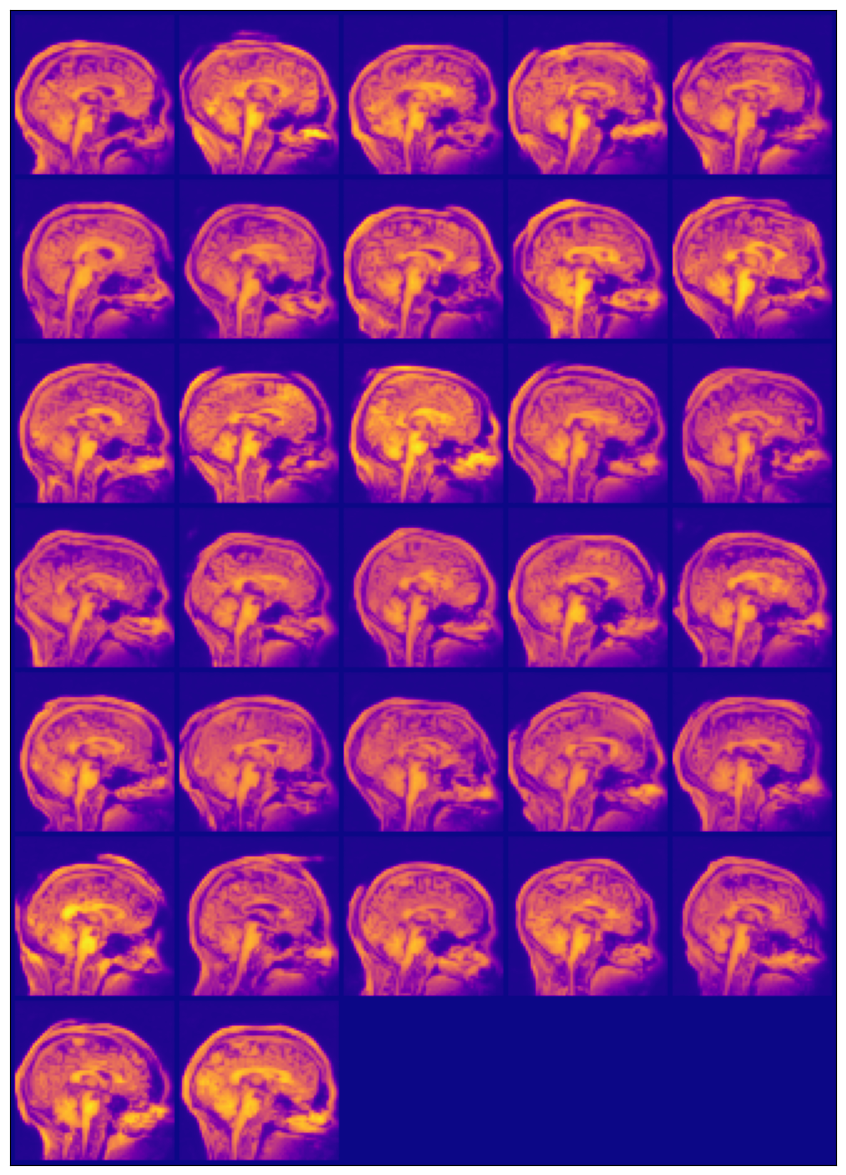

In [ ]:
save_path = "/content/drive/MyDrive/Colab Notebooks/samples_final.npy"
loaded_samples = np.load(save_path)
loaded_tensor = torch.from_numpy(loaded_samples)
reshaped_tensor = loaded_tensor.view(len(samples_final), 32, 1, 64, 64)

# Print out the new shape
print(f"Reshaped tensor shape: {reshaped_tensor.shape}")
plot_batch(reshaped_tensor[0].cpu())

<br>

---

<br>

## **Question 2**  (25%)

Using the data generated in **Question 1**, create a PyTorch `TensorDataset` and a `DataLoader` for the training set.

Using the provided corrupted images inside `test_set.npy`, create another `TensorDataset` and a `DataLoader` for the test set.

The training dataset should provide batches of brain images generated in **Question 1** and should corrupt these images appropriately so that they resemble images in the test set. The dataset should also pair each image with its corresponding un-corrupted image as a label.

The test dataset should provide the corrupted images provided, for which no labels are available.

Display here ten images of your training dataset and ten images of your test dataset, and their corresponding labels when available.

<br>

### Inspecting corruption

Before creating the dataset we need to understand the underlying pattern of the corruption. If we sum all of the images we notice clearly that the corruption overlaps between images.

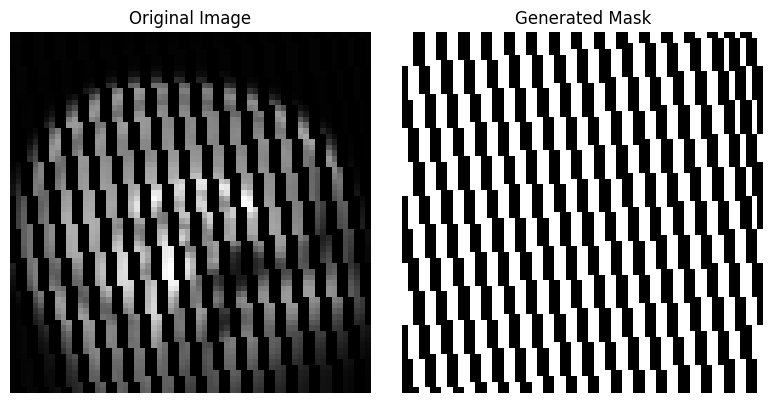

In [ ]:
total_img = data_test[0].squeeze()
for i in range(1,len(data_test)):
  total_img += data_test[i].squeeze()

final_mask = total_img.squeeze() != 0

plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(total_img, cmap="gray")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Generated Mask")
plt.imshow(final_mask, cmap="gray")
plt.axis("off")

plt.tight_layout()
plt.show()

Moreover, we notice that the different corruption paterns only differ from image to image by 2 pixels. Thus, we can consider our mask either to be any of the masks or the resulting mask of the we get after summing all the images. Either approach seems resonable and result in similar masks. For simplicity we will consider the mask of the image number 13 (we could have chosen another mask).

With the following two functions we can apply the corruption mask to image or batch and visualize the result:

In [ ]:
def view_mask_and_plot(image_to_apply, mask):

  image_to_apply_masked = image_to_apply.cpu().numpy() * mask  # Inverse mask to keep non-zero points

  # Plot the original and masked images
  plt.subplot(1, 2, 1)
  plt.imshow(image_to_apply.cpu().numpy(), cmap="plasma")  # Convert to NumPy for plotting
  plt.title("Original Image")
  plt.axis("off")

  plt.subplot(1, 2, 2)
  plt.imshow(image_to_apply_masked, cmap="gray")  # Convert to NumPy for plotting
  plt.title("Masked Image")
  plt.axis("off")

  plt.show()

def view_mask_and_plot_batch(images, mask):

    # Apply the mask to the entire batch: Apply mask to each image
    images_masked = images * mask

    # Set up the plot
    batch_size = images.shape[0]
    n_cols = 5  # Number of columns for displaying images
    n_rows = (batch_size + n_cols - 1) // n_cols  # Calculate number of rows needed

    plt.figure(figsize=(15, n_rows * 3))

    for i in range(batch_size):
        plt.subplot(n_rows, n_cols, i + 1)
        # Convert tensor to NumPy array and plot the masked image
        plt.imshow(images_masked[i].cpu().numpy().squeeze(), cmap="gray")  # Squeeze to remove single channel dimension
        plt.axis("off")

    plt.tight_layout()
    plt.show()

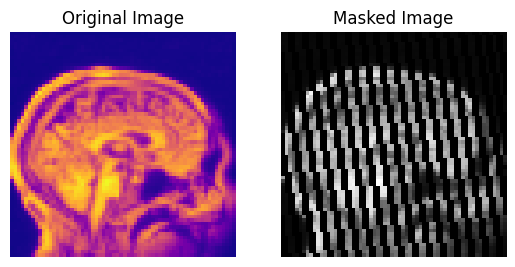

In [ ]:
mask = data_test[12].squeeze() != 0
view_mask_and_plot(loaded_tensor[0][0].squeeze(), mask)

In [ ]:
reshaped_tensor[0].cpu().shape

torch.Size([32, 1, 64, 64])

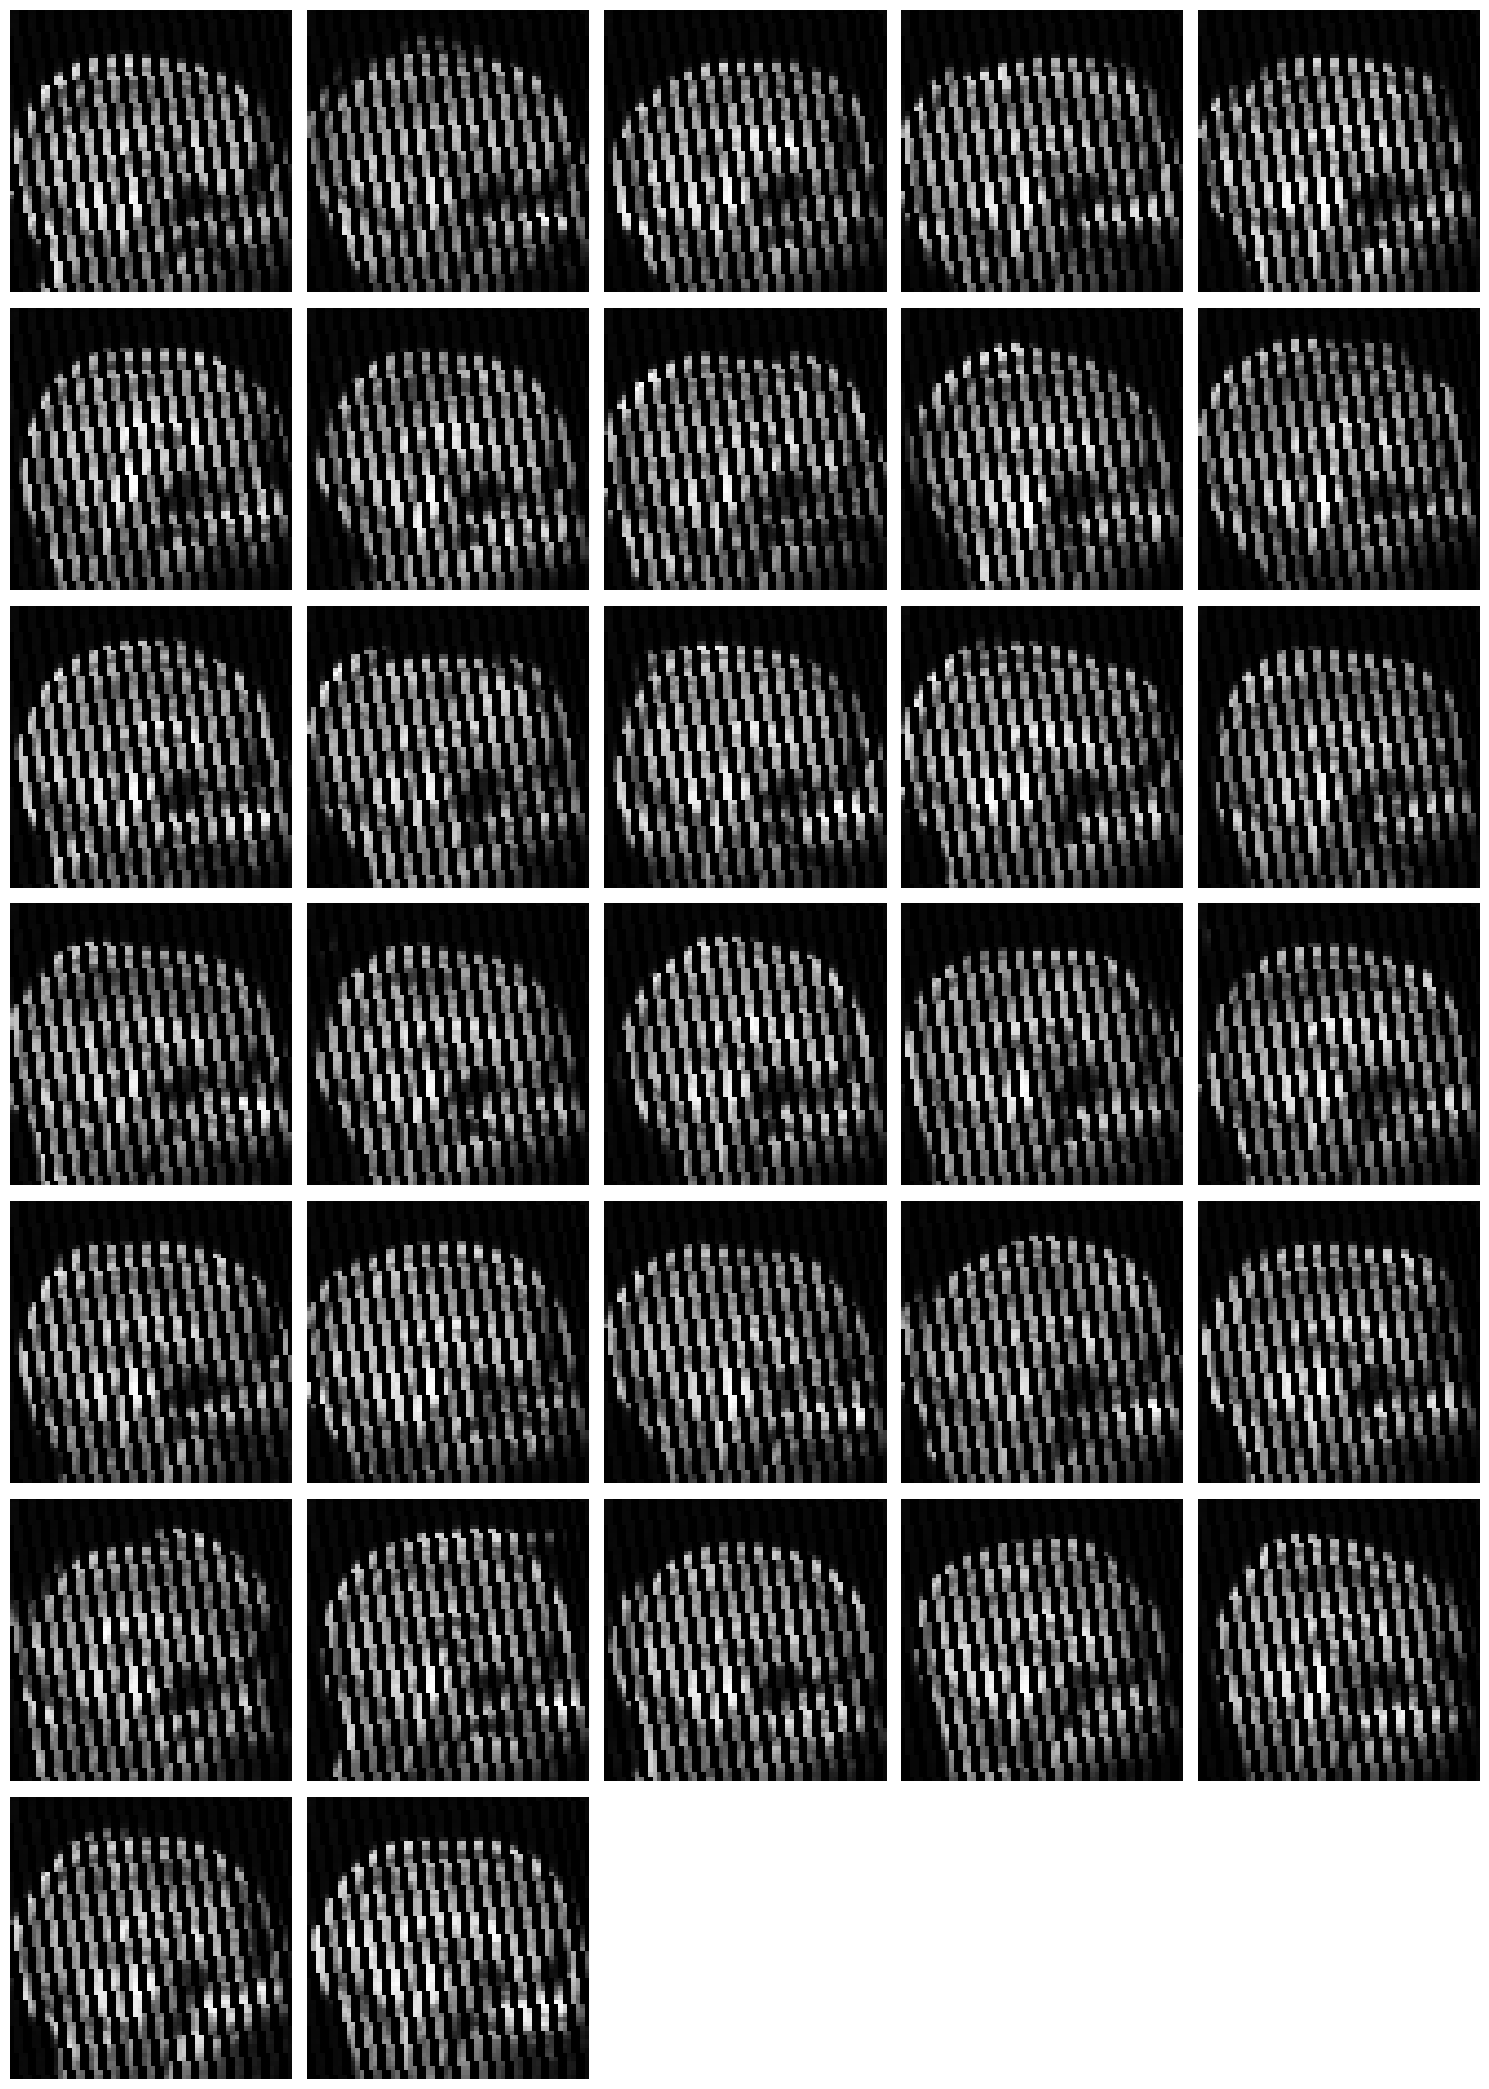

In [ ]:
view_mask_and_plot_batch(reshaped_tensor[0].cpu(), final_mask)


### TensorDataset and a DataLoader for the test set

In [ ]:
class CorruptedTestDataset(Dataset):
    def __init__(self, data_path):
        """
        Dataset for test data consisting only of corrupted images.
        - data_path: Path to the test_set.npy file (corrupted images).
        """
        self.data = torch.from_numpy(np.load(data_path))  # Load corrupted images

    def __getitem__(self, idx):
        corrupted_image = self.data[idx]
        return corrupted_image

    def __len__(self):
        return len(self.data)

### TensorDataset and a DataLoader for the training set

In [ ]:
mask = data_test[12].squeeze() != 0

class CorruptedDataset(Dataset):
    def __init__(self, data_path, transform=None):

        self.data = torch.from_numpy(np.load(data_path))
        self.transform = transform
        self.mask = torch.from_numpy(mask).type(torch.float32)

    def __getitem__(self, idx):
        sample = self.data[idx]

        if self.transform:
            sample = self.transform(sample)

        masked_sample = sample * self._filter_mask_with_random_square()
        # masked_sample = sample * self.mask

        return masked_sample, sample

    def _filter_mask_with_random_square(self):
        mask_size = self.mask.shape[0]

        # Minimum unfiltered area size
        min_unfiltered_size = 0

        # Random size for the square, ensuring at least 32x32 is left unfiltered
        square_size = random.randint(30, mask_size - min_unfiltered_size)

        # Random top-left corner within the mask bounds, ensuring square stays inside the mask
        row = random.randint(0, mask_size - square_size)
        col = random.randint(0, mask_size - square_size)

        # Define the bottom-right corner
        top_left = (row, col)
        bottom_right = (row + square_size, col + square_size)

        # Create a copy of the mask to apply the changes
        mask_copy = self.mask.clone()

        # Set the ones outside the square to zero
        mask_copy[:top_left[0], :] = 1
        mask_copy[top_left[0]:bottom_right[0], :top_left[1]] = 1
        mask_copy[bottom_right[0]:, :] = 1
        mask_copy[top_left[0]:bottom_right[0], bottom_right[1]:] = 1

        return mask_copy


    def __len__(self):
        return len(self.data)

    def __str__(self):
        return (
            f"CorruptedDataset:\n"
            f"  Number of samples: {len(self.data)}\n"
            f"  Data shape: {self.data.shape}\n"
            f"  Mask shape: {self.mask.shape}\n"
            f"  Transform: {self.transform is not None}\n")

### Defining the transforms

In [ ]:
loaded_samples = np.load(save_path)
loaded_tensor = torch.from_numpy(loaded_samples)
reshaped_tensor = loaded_tensor.view(len(samples_final), 32, 1, 64, 64)

print("min/max:", reshaped_tensor.min().item(), "/", reshaped_tensor.max().item())
print("mean: ", torch.mean(reshaped_tensor.float()).item())
print("std: ", torch.std(reshaped_tensor.float()).item())

min/max: 0.00835418701171875 / 0.74853515625
mean:  0.19586345553398132
std:  0.14450879395008087


In [ ]:
data_path = "/content/drive/MyDrive/Colab Notebooks/samples_final.npy"

transform = Compose([lambda x: x.float(),])
dataset = CorruptedDataset(data_path, transform=transform)

In [ ]:
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

Reshaped tensor shape: torch.Size([128, 32, 1, 64, 64])


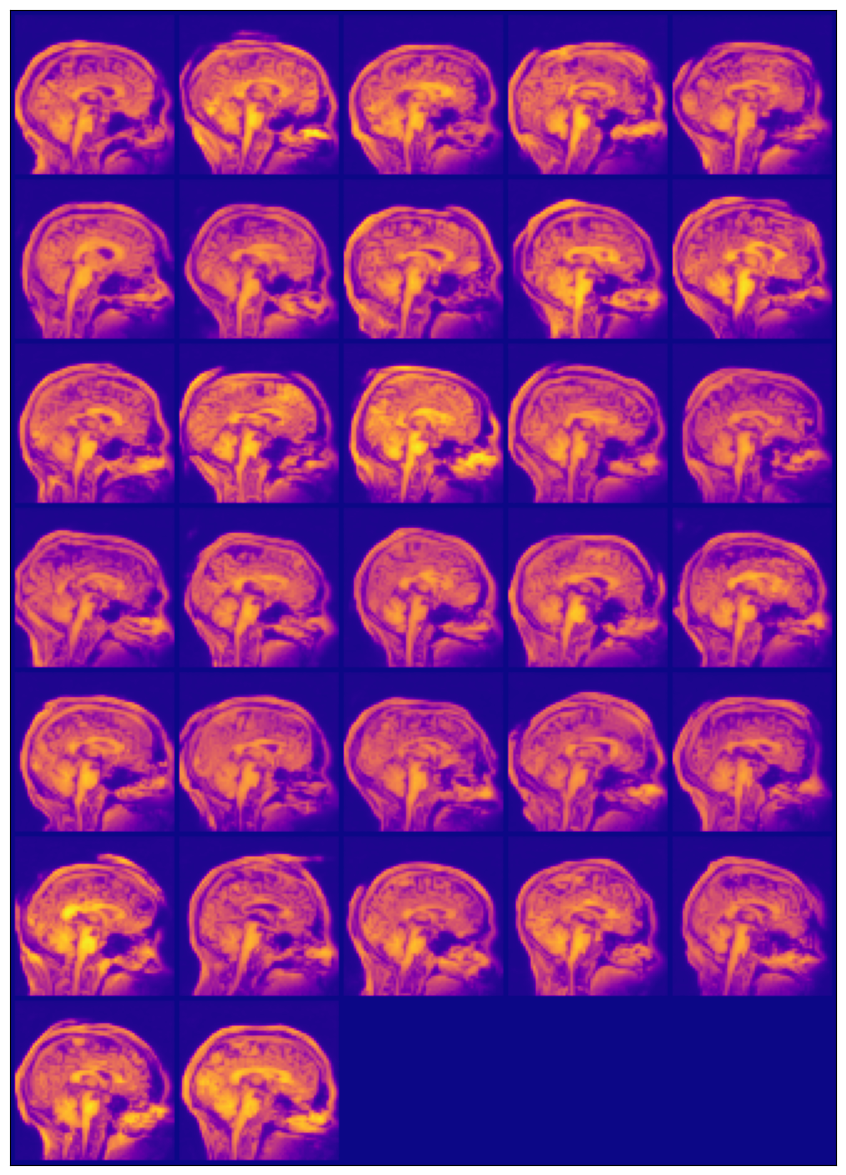

In [ ]:
data_path="/content/drive/MyDrive/Colab Notebooks/samples_final.npy"
reshaped_tensor = CorruptedDataset(data_path).data.view(len(samples_final), 32, 1, 64, 64)

print(f"Reshaped tensor shape: {reshaped_tensor.shape}")
plot_batch(reshaped_tensor[0].cpu())

Masked Batch Shape: torch.Size([32, 1, 64, 64])
Original Batch Shape: torch.Size([32, 1, 64, 64])


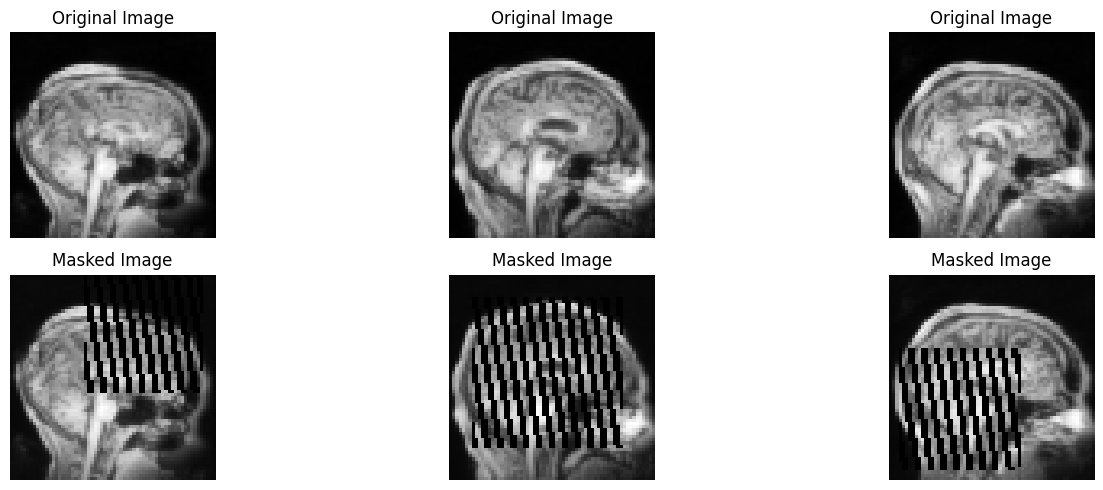

In [ ]:
for masked_batch, original_batch in dataloader:
    print("Masked Batch Shape:", masked_batch.shape)
    print("Original Batch Shape:", original_batch.shape)

    # Display the first few images in the batch
    num_images_to_show = min(3, masked_batch.shape[0])  # Show up to 5 images

    plt.figure(figsize=(15, 5))
    for i in range(num_images_to_show):
        # Original Image
        plt.subplot(2, num_images_to_show, i + 1)
        plt.imshow(original_batch[i].cpu().numpy().squeeze(), cmap="gray")
        plt.title("Original Image")
        plt.axis("off")

        # Masked Image
        plt.subplot(2, num_images_to_show, num_images_to_show + i + 1)
        plt.imshow(masked_batch[i].cpu().numpy().squeeze(), cmap="gray")
        plt.title("Masked Image")
        plt.axis("off")

    plt.tight_layout()
    plt.show()
    break

In [ ]:
def split_dataset(dataset, test_size=0.2, random_state=42):
    """Split the dataset into training and validation sets."""
    # Create indices for splitting
    indices = list(range(len(dataset)))

    # Split the indices into train and validation
    train_indices, valid_indices = train_test_split(
        indices, test_size=test_size, random_state=random_state
    )

    # Use Subset to create train and validation datasets
    train_dataset = Subset(dataset, train_indices)
    valid_dataset = Subset(dataset, valid_indices)

    return train_dataset, valid_dataset

train_dataset, valid_dataset = split_dataset(dataset, test_size=0.2, random_state=42)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=32, shuffle=False)

Masked Batch Shape: torch.Size([32, 1, 64, 64])
Original Batch Shape: torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])


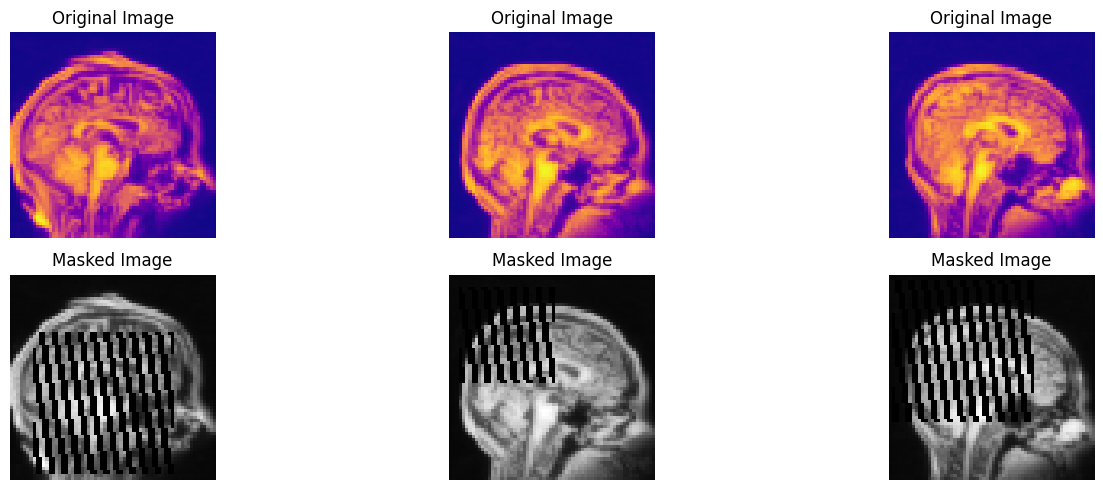

In [ ]:
for masked_batch, original_batch in valid_loader:
    print("Masked Batch Shape:", masked_batch.shape)
    print("Original Batch Shape:", original_batch.shape)

    # Display the first few images in the batch
    num_images_to_show = min(3, masked_batch.shape[0])  # Show up to 5 images

    plt.figure(figsize=(15, 5))
    for i in range(num_images_to_show):
        # Original Image
        plt.subplot(2, num_images_to_show, i + 1)
        plt.imshow(original_batch[i].cpu().numpy().squeeze(), cmap="plasma")
        plt.title("Original Image")
        plt.axis("off")

        # Masked Image
        plt.subplot(2, num_images_to_show, num_images_to_show + i + 1)
        plt.imshow(masked_batch[i].cpu().numpy().squeeze(), cmap="gray")
        plt.title("Masked Image")
        plt.axis("off")

    plt.tight_layout()
    plt.show()
    break

In [ ]:
train_batch_sample, train_batch_targets = next(iter(train_loader))

print("min/max:", train_batch_sample.min().item(), "/", train_batch_sample.max().item())
print("mean: ", torch.mean(train_batch_sample.float()).item())
print("std: ", torch.std(train_batch_sample.float()).item())

min/max: 0.0 / 0.59619140625
mean:  0.13850705325603485
std:  0.14795464277267456


### Pre-processing & Data Agumentation discussion

As I was searching for the best architecture and hyperparemeters, I was constantly testing new approaches to transforming the data and checking for improvements.

Since the data is close to zero and the standard deviation is small I tried to apply the following normalization: transform = Compose([lambda x: x.float(), Normalize(0.19575859606266022, 0.14455251395702362)]). However, the loss of information resulted in worse results and since this operation is not commutative with the application of the mask, in get item applying the mask resulted in corrupted values that do not correspond to zero.

In order to increase generalizabilty I tried to augment the data by applying only filtering mask and only selecting the 0 values in certain random squares. If the filter squares are very small this will result in an inflated MSE, thus I chose the filter squares have close dimensions to the original mask. Overall, the results do not change significantly since the masks are almost similar across generated images and test set. Considering that there sometimes there were improvements and possibly and enhanced predictive power, I keep this data augmentation.

<br>

---

<br>

## **Question 3** (50%)

Using the dataset created in **Question 2**, design and train an architecture to recover the missing image lines of the provided test dataset.

Once you have trained your architecture, display here ten images of the test set with the recovered lines filled in.

Additionally, save the test data with the missing values filled in into a numpy file called `test_set_nogaps.npy`. These images should be **in the same order** as those in the `test_set.npy` file and should have the same pixel size of 64x64. **Any images not contained in the `test_set_nogaps.npy` file or incorrectly ordered will not be marked.**

You have freedom to choose an architecture that you consider appropriate to solve this problem. However, you will need to train your chosen architecture as part of the assessment: **pre-trained networks are not allowed**.

You will be assessed by the quality of your predictions of the missing data values and additional marks will be given for originality in your network design choices. You should include, as part of your answer, a paragraph explaining the architecture you have chosen and any additional design choices and hyperparameters that have been important to build your solution.

This is an open-book assessment and you are encouraged to use resources online, including  tools like chatGPT. However, make sure to always mention the sources for your code and ideas, including websites, papers, and tools like chatGPT.

<br>

In [ ]:
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = True  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = True

    return True


def set_device(device="cpu", idx=0):
    if device != "cpu":
        if torch.cuda.device_count() > idx and torch.cuda.is_available():
            print("Cuda installed! Running on GPU {} {}!".format(idx, torch.cuda.get_device_name(idx)))
            device="cuda:{}".format(idx)
        elif torch.cuda.device_count() > 0 and torch.cuda.is_available():
            print("Cuda installed but only {} GPU(s) available! Running on GPU 0 {}!".format(torch.cuda.device_count(), torch.cuda.get_device_name()))
            device="cuda:0"
        else:
            device="cpu"
            print("No GPU available! Running on CPU")
    return device

device = set_device("cuda")

Cuda installed! Running on GPU 0 NVIDIA A100-SXM4-40GB!


In [ ]:
def train(model, optimizer, criterion, data_loader):
    model.train()
    train_loss = 0.
    for input, target in data_loader:
        input, target = input.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(input)
        loss = criterion(output, target)
        loss.backward()
        train_loss += loss*input.size(0)
        optimizer.step()
    train_loss = train_loss / len(data_loader.dataset)
    return train_loss


def valid(model, criterion, data_loader):
    model.eval()
    valid_loss = 0.
    with torch.no_grad():
        for input, target in data_loader:
            input, target = input.to(device), target.to(device)
            output = model(input)
            loss = criterion(output, target)
            valid_loss += loss*input.size(0)
        valid_loss = valid_loss / len(data_loader.dataset)
        return valid_loss

In [ ]:
mseloss = nn.MSELoss() # metric considered for all the training

For all the architectures chosen first I overfitted a single batch to check if the architecture is well defined. Only the main conclusions are presented on this notebook for the sake of simplification

### Simple Auto Encoder


To choose the best architecture first I started with a simple choice of an Auto Encoder. The models seems to generalize well and to have reduced MSE. However, by increasing the complexity I exptec the MSE to go down.

In [ ]:
class SimpleAE(nn.Module):
    def __init__(self):
        super(SimpleAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # Downsample by 2x
        )

        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),  # Upsample by 2x
            nn.ReLU(),
            nn.Conv2d(32, 1, kernel_size=3, padding=1)  # Output layer
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.bottleneck(x)
        x = self.decoder(x)
        return x

In [ ]:
nepochs = 60
lr = 1e-4
batch_size = 128
model = SimpleAE().to(device)
model_AE = model.to(torch.float32)
optimiser = torch.optim.Adam(params=model.parameters(), lr=lr)

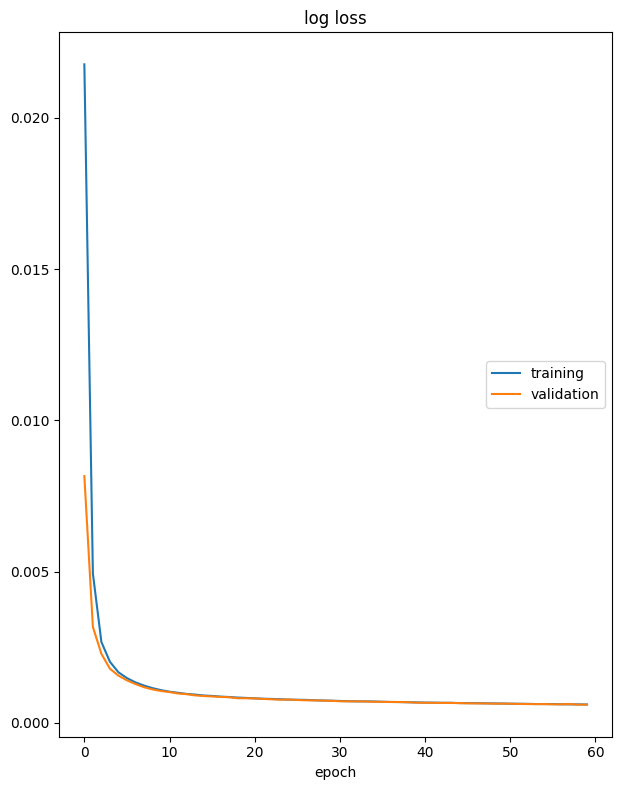

log loss
	training         	 (min:    0.001, max:    0.022, cur:    0.001)
	validation       	 (min:    0.001, max:    0.008, cur:    0.001)


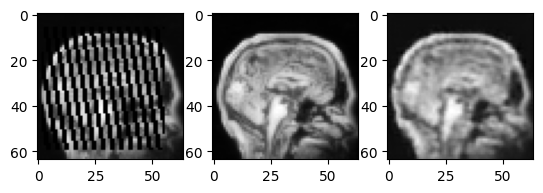

In [ ]:
liveloss = PlotLosses()
for i in range(nepochs):
    train_loss = train(model, optimiser, mseloss, train_loader)
    valid_loss = valid(model, mseloss, valid_loader)

    # Liveloss plot
    logs = {}
    logs['' + 'log loss'] = train_loss.item()
    logs['val_' + 'log loss'] = valid_loss.item()
    liveloss.update(logs)
    liveloss.draw()

    # Visualise a random validation sample
    valid_sample, valid_target = valid_dataset[torch.randint(0, len(valid_dataset), (1,)).item()]
    output_sample = model(valid_sample.unsqueeze(0).to(device))
    fig, axs = plt.subplots(1, 3)
    axs[0].imshow(valid_sample[0].cpu(), cmap="gray")
    axs[1].imshow(valid_target[0].cpu(), cmap="gray")
    axs[2].imshow(output_sample[0, 0].detach().cpu(), cmap="gray")
    plt.show()

### UNet64 (FINAL MODEL THAT WAS CHOSEN)

Choice is justified at the end.

In [ ]:
class UNet64(nn.Module):
    def __init__(self):
        super(UNet64, self).__init__()
        self.encoder1 = self.conv_block(1, 64)
        self.encoder2 = self.conv_block(64, 128)
        self.encoder3 = self.conv_block(128, 256)
        self.bottleneck = self.conv_block(256, 512)
        self.upconv3 = self.upconv_block(512, 256)
        self.upconv2 = self.upconv_block(256, 128)
        self.upconv1 = self.upconv_block(128, 64)
        self.final = nn.Conv2d(64, 1, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def upconv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            self.conv_block(out_channels, out_channels)
        )

    def forward(self, x):
        enc1 = self.encoder1(x)  # 64x64
        enc2 = self.encoder2(nn.MaxPool2d(2)(enc1))  # 32x32
        enc3 = self.encoder3(nn.MaxPool2d(2)(enc2))  # 16x16
        bottleneck = self.bottleneck(nn.MaxPool2d(2)(enc3))  # 8x8
        dec3 = self.upconv3(bottleneck) + enc3  # 16x16
        dec2 = self.upconv2(dec3) + enc2  # 32x32
        dec1 = self.upconv1(dec2) + enc1  # 64x64
        return torch.tanh(self.final(dec1))

In [ ]:
nepochs = 40
lr = 1e-3
batch_size = 128
model = UNet64().to(device)
model_UNet64 = model.to(torch.float32)
mseloss = nn.MSELoss()

optimiser = torch.optim.Adam(params=model.parameters(), lr=lr)

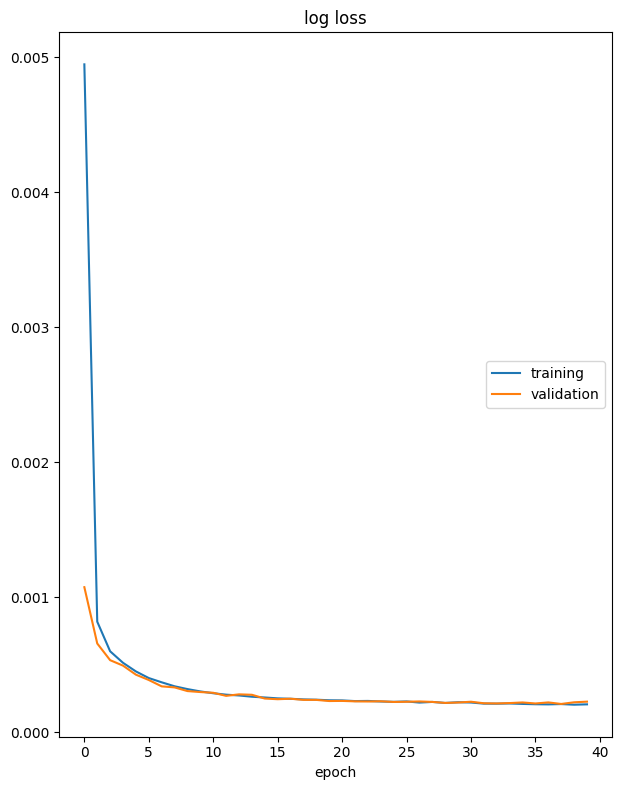

log loss
	training         	 (min:    0.000, max:    0.005, cur:    0.000)
	validation       	 (min:    0.000, max:    0.001, cur:    0.000)


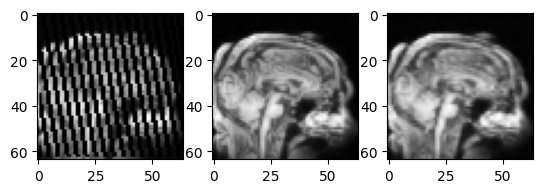

In [ ]:
liveloss = PlotLosses()
for i in range(nepochs):
    train_loss = train(model, optimiser, mseloss, train_loader)
    valid_loss = valid(model, mseloss, valid_loader)

    # Liveloss plot
    logs = {}
    logs['' + 'log loss'] = train_loss.item()
    logs['val_' + 'log loss'] = valid_loss.item()
    liveloss.update(logs)
    liveloss.draw()

    # Visualise a random validation sample
    valid_sample, valid_target = valid_dataset[torch.randint(0, len(valid_dataset), (1,)).item()]
    output_sample = model(valid_sample.unsqueeze(0).to(device))
    fig, axs = plt.subplots(1, 3)
    axs[0].imshow(valid_sample[0].cpu(), cmap="gray")
    axs[1].imshow(valid_target[0].cpu(), cmap="gray")
    axs[2].imshow(output_sample[0, 0].detach().cpu(), cmap="gray")
    plt.title("")
    plt.show()

### Enhanced UNet

Despite the models generalizing well and achieving low MSE for the last architectures, I sought to enhance mt UNet building upon the last one. It adds more layers to the model, both in the encoder and decoder, with the introduction of an extra bottleneck and an additional upsampling layer. Also it changes ReLU to LeakyReLU (which would be helpful) if there were vanishing gradients.

In [ ]:
class EnhancedUNet64(nn.Module):
    def __init__(self):
        super(EnhancedUNet64, self).__init__()

        # Encoder path
        self.encoder1 = self.conv_block(1, 64)
        self.encoder2 = self.conv_block(64, 128)
        self.encoder3 = self.conv_block(128, 256)
        self.encoder4 = self.conv_block(256, 512)

        # Bottleneck (bottleneck layer before decoder)
        self.bottleneck = self.conv_block(512, 1024)

        # Decoder path with skip connections
        self.upconv4 = self.upconv_block(1024, 512)
        self.upconv3 = self.upconv_block(512, 256)
        self.upconv2 = self.upconv_block(256, 128)
        self.upconv1 = self.upconv_block(128, 64)

        # Final layer to reduce to 1 channel output
        self.final = nn.Conv2d(64, 1, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(out_channels),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(out_channels)
        )

    def upconv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x):
        # Encoder
        enc1 = self.encoder1(x)  # 64x64
        enc2 = self.encoder2(nn.MaxPool2d(2)(enc1))  # 32x32
        enc3 = self.encoder3(nn.MaxPool2d(2)(enc2))  # 16x16
        enc4 = self.encoder4(nn.MaxPool2d(2)(enc3))  # 8x8

        # Bottleneck
        bottleneck = self.bottleneck(nn.MaxPool2d(2)(enc4))  # 4x4

        # Decoder with skip connections
        dec4 = self.upconv4(bottleneck) + enc4  # 8x8
        dec3 = self.upconv3(dec4) + enc3  # 16x16
        dec2 = self.upconv2(dec3) + enc2  # 32x32
        dec1 = self.upconv1(dec2) + enc1  # 64x64

        # Final output layer
        return torch.tanh(self.final(dec1))

model = EnhancedUNet64()

In [ ]:
nepochs = 40
lr = 1e-3
batch_size = 128
model = EnhancedUNet64().to(device)
model_EnhancedUNet64 = model.to(torch.float32)

optimiser = torch.optim.Adam(params=model.parameters(), lr=lr)

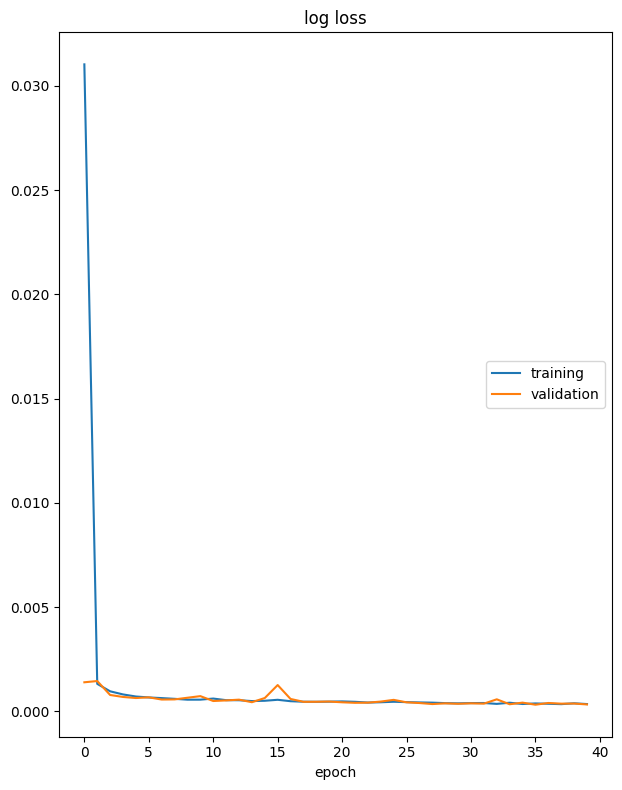

log loss
	training         	 (min:    0.000, max:    0.031, cur:    0.000)
	validation       	 (min:    0.000, max:    0.001, cur:    0.000)


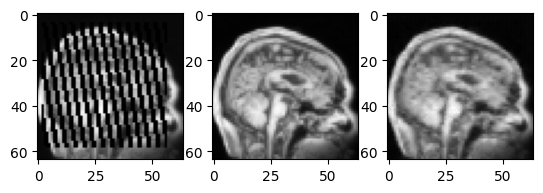

In [ ]:
liveloss = PlotLosses()
for i in range(nepochs):
    train_loss = train(model, optimiser, mseloss, train_loader)
    valid_loss = valid(model, mseloss, valid_loader)

    # Liveloss plot
    logs = {}
    logs['' + 'log loss'] = train_loss.item()
    logs['val_' + 'log loss'] = valid_loss.item()
    liveloss.update(logs)
    liveloss.draw()

    # Visualise a random validation sample
    valid_sample, valid_target = valid_dataset[torch.randint(0, len(valid_dataset), (1,)).item()]
    output_sample = model(valid_sample.unsqueeze(0).to(device))
    fig, axs = plt.subplots(1, 3)
    axs[0].imshow(valid_sample[0].cpu(), cmap="gray")
    axs[1].imshow(valid_target[0].cpu(), cmap="gray")
    axs[2].imshow(output_sample[0, 0].detach().cpu(), cmap="gray")
    plt.show()

In [ ]:
import matplotlib.pyplot as plt
import torch

def plot_predictions(model, test_loader):
    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():  # Disable gradient calculation
        # Get the first batch from the test set
        data_iter = iter(test_loader)
        images, _ = next(data_iter)  # Assuming test_loader returns (image, label) tuples

        # Ensure the model runs on the correct device (e.g., CPU or GPU)
        if torch.cuda.is_available():
            model = model.cuda()
            images = images.cuda()

        # Get the predictions from the model
        predictions = model(images)

        # Convert images and predictions back to CPU and to numpy for plotting
        images = images.cpu().numpy()
        predictions = predictions.cpu().numpy()

        # Create a figure to plot the images
        plt.figure(figsize=(15, 5))

        for i in range(10):  # Plot the first 10 images
            plt.subplot(2, 10, i + 1)
            plt.imshow(images[i, 0], cmap='gray')  # Show original image (assuming grayscale)
            plt.axis('off')
            if i == 0:
                plt.title("Original")

            plt.subplot(2, 10, i + 11)
            plt.imshow(predictions[i, 0], cmap='gray')  # Show predicted image (assuming grayscale)
            plt.axis('off')
            if i == 0:
                plt.title("Predicted")

        plt.tight_layout()
        plt.show()


In [ ]:
test_dataset = CorruptedTestDataset(data_path='/content/drive/MyDrive/Colab Notebooks/test_set.npy')
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

In [ ]:
def plot_predictions(model, test_loader, num_images=10, cmap='plasma'):
    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():  # Disable gradient calculation
        # Get the first batch from the test set
        data_iter = iter(test_loader)
        images = next(data_iter)  # Assuming test_loader returns (image, label) tuples

        # Ensure the model runs on the correct device (e.g., CPU or GPU)
        if torch.cuda.is_available():
            model = model.cuda()
            images = images.cuda()

        # Get the predictions from the model
        predictions = model(images)

        # Convert images and predictions back to CPU and to numpy for plotting
        images = images.squeeze().cpu().numpy()
        predictions = predictions.squeeze().cpu().numpy()

        fig, axs = plt.subplots(2, num_images, figsize=(15, 5))

        # Plot original images
        for i in range(num_images):
            axs[0, i].imshow(images[i], cmap=cmap)
            axs[0, i].axis('off')
            axs[0, i].set_title(f"Original {i+1}")

        # Plot predicted images
        for i in range(num_images):
            axs[1, i].imshow(predictions[i], cmap=cmap)
            axs[1, i].axis('off')
            axs[1, i].set_title(f"Predicted {i+1}")

        plt.tight_layout()
        plt.show()

### Final model: UNet64

Despite the added complexity of EnchancedUNet the results were not better and there was an unexpected bump in the validation loss.  Considering the results, I note that more layers and higher sensibility to details is not necessarily always better. In this case more layers than the ones in the UNet64 lead to images that are blurrier. Since the UNet64 model results are already very satisfatory and prioritizing simplicity I chose this as my final model.

Throughout the notebook other remarks important were made about particular choices for example about the data augmentation. Other important design choices of the final model

- final activation functions is tanh: sigmoid fails possibily because there are too many values close to zero where it saturates.

- learning rate of 1e-3: I started with a big learning step and reduced it until I got the best result. For a very small learning rate the model seems to be stuck at a local minima.

- batch size = 128: best balance between computational efficiency and stable gradient estimates, leveraging parallelism without overwhelming memory capacity or causing noisy updates.

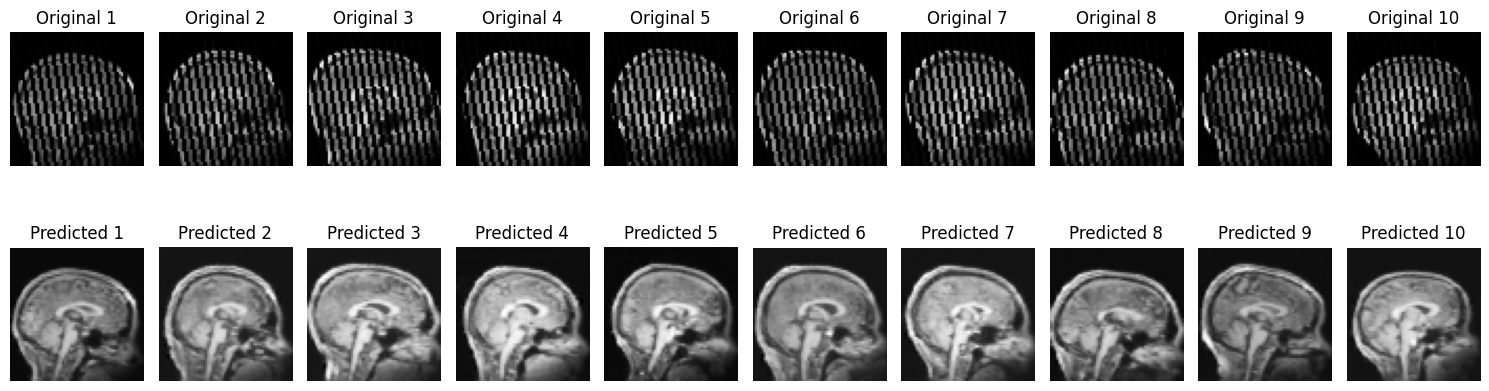

In [ ]:
plot_predictions(model_UNet64, test_loader, num_images=10, cmap='gray')

In [ ]:
import torch
import numpy as np
from torch.utils.data import DataLoader

def process_and_save_images(model, test_dataset, save_path, batch_size=10, device='cuda' if torch.cuda.is_available() else 'cpu'):

    model.eval()
    model.to(device)

    # Create a DataLoader for batch processing
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    processed_images = []

    # Disable gradient computation
    with torch.no_grad():
        for images in test_loader:
            # Move images to the specified device
            images = images.to(device)

            # Apply the model to reconstruct the images
            reconstructed = model(images)

            # Convert the reconstructed images to CPU and NumPy
            processed_images.append(reconstructed.cpu().numpy())

    # Concatenate all processed images along the batch dimension
    processed_images = np.concatenate(processed_images, axis=0)

    # Save the processed images to the specified file path
    np.save(save_path, processed_images)
    print(f"Processed images saved to {save_path}")

path_images = "/content/drive/MyDrive/Colab Notebooks/test_set_nogaps.npy"
process_and_save_images(model_UNet64, test_dataset, path_images)

Processed images saved to /content/drive/MyDrive/Colab Notebooks/test_set_nogaps.npy


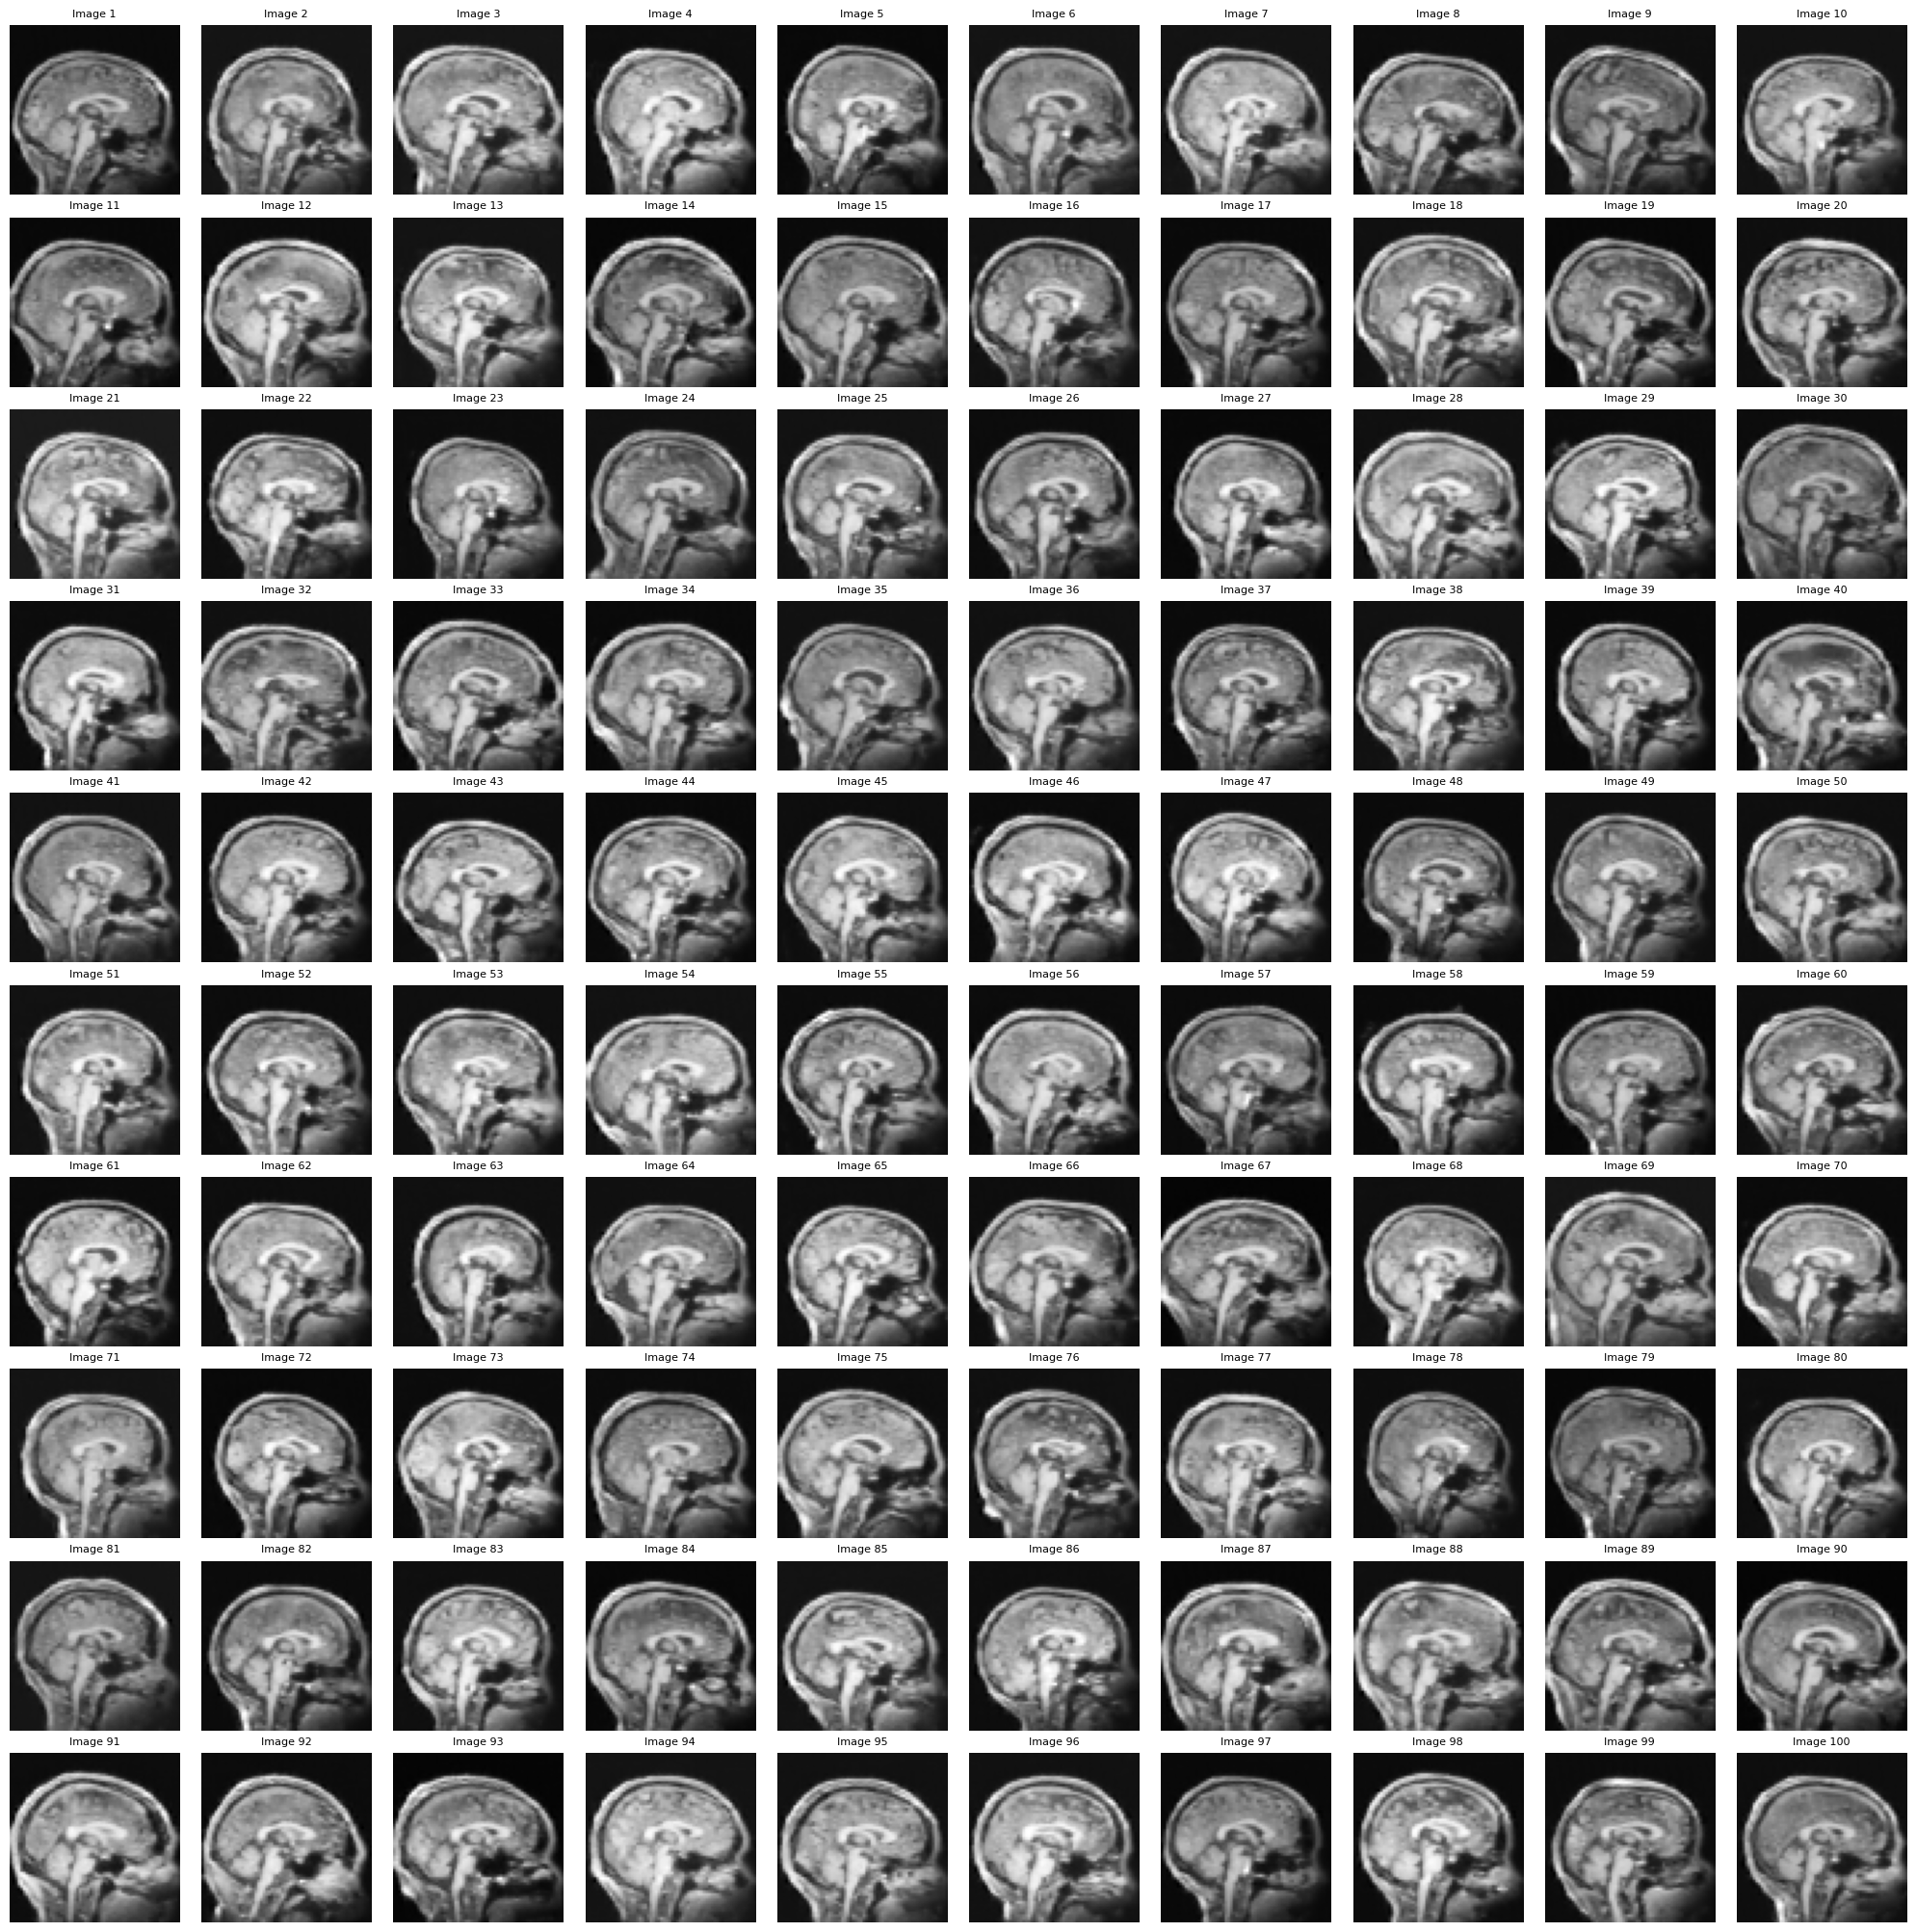

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_all_images(images_path, grid_shape=(10, 10), cmap='gray'):
    """
    Plots all images from a given NumPy file in a grid layout.

    Args:
        images_path (str): Path to the NumPy file containing the images.
        grid_shape (tuple): Shape of the grid as (rows, columns).
        cmap (str): Color map to use for plotting the images.
    """
    # Load the images from the NumPy file
    images = np.load(images_path)

    # Ensure the number of images matches the grid size
    num_images = images.shape[0]
    rows, cols = grid_shape
    assert rows * cols >= num_images, "Grid shape must fit all images."

    # Reshape if the images have a single channel
    if images.shape[1] == 1:
        images = images[:, 0, :, :]

    # Create the grid for plotting
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    axes = axes.flatten()

    for i in range(rows * cols):
        if i < num_images:
            axes[i].imshow(images[i], cmap=cmap)
            axes[i].axis('off')  # Remove axis labels for clarity
            axes[i].set_title(f"Image {i + 1}", fontsize=8)
        else:
            axes[i].axis('off')  # Hide unused subplots

    plt.tight_layout(pad=0.5)
    plt.show()

# Example usage
plot_all_images("/content/drive/MyDrive/Colab Notebooks/test_set_nogaps.npy", grid_shape=(10, 10), cmap='gray')

In [ ]:
torch.save(model_UNet64.state_dict(), '/content/drive/MyDrive/Colab Notebooks/model_UNet64.pth')